# Extracting

Let's begin by extracting our data into pandas dataframes. I have created a simple python module just for that task. 

All dataframes will have duplicate rows deleted and empty strings will be substituted with NaN values. This is a very basic transformation that can be done for almost any data. Further transformations will depend on what we see in our dataframes.

In [339]:
from etl import extract, config
import pandas as pd

datasources = 'a'
product_invoices_path = './data/product_invoices/'
product_package_types_path = './data/product_package_types/'
product_shipments_path = './data/product_shipments/'
provider_invoices_path = './data/provider_invoices/'
provider_prices_path = './data/provider_prices/'
extractor = extract.Extractor(datasources)

product_invoices_df = extractor.load_json_files_to_df(product_invoices_path)
product_package_types_df = extractor.load_json_files_to_df(product_package_types_path)
product_shipments_df = extractor.load_json_files_to_df(product_shipments_path)
provider_invoices_df = extractor.load_json_files_to_df(provider_invoices_path)
provider_prices_df = extractor.load_json_files_to_df(provider_prices_path)


# Checking and Transforming

Now let us check our dataframes one by one and fix anything funky that might be going on with them.

I will focus on missing data and potential primary keys that are not unique.

In [264]:
# the list of transactions where we have collected the shipment fee from the buyers
product_invoices_df

,transaction_id,amount,user_invoice_date
0,221271390,3.150000,2018-12-20
1,153588634,3.150000,2018-08-24
2,270671460,2.400000,2019-03-01
3,158409145,2.730000,2018-09-04
4,178911135,2.730000,2018-10-18
...,...,...,...
55409,131206431,2.400000,2018-06-13
55410,252787333,2.400000,2019-02-08
55411,250082599,2.400000,2019-01-30
55412,244563332,2.730000,2019-01-31


In [291]:
isTransIdUnique = product_invoices_df["transaction_id"].is_unique 
print("transaction_id is Unique: " + str(isTransIdUnique) + '\n')

print('Number of missing values:')
print (product_shipments_df.isnull().sum())

transaction_id is Unique: True

Number of missing values:
tracking_code             0
from_country              0
to_country                0
package_type_id           0
transaction_id            0
shipping_label_created    0
buyer_id                  0
seller_id                 0
dtype: int64


In [265]:
#the list of package types we have on our platform that a seller can select.
product_package_types_df

,id,description
0,7,Ã‰paiss. max 3cm 0.25kg
1,8,0.75kg
2,9,2kg
3,10,0.5kg
4,11,1kg
...,...,...
129,275,"Max. 20 kg, 120 x 60 x 60 cm"
130,276,"Max. 20 kg, 120 x 60 x 60 cm"
131,277,"Max. 20 kg, 120 x 60 x 60 cm"
132,292,"Max. 10 kg, 100 Ã— 50 Ã— 50 cm"


The description data in the product_package_types_df looks quite ugly. It includes both dimensions and weight of the packages. Dimentions are not referred to in any of the other tables. We will transform this data so that a 'max kg' value is saved in a separate column. This way we can make the most of the product_package data - for example, we can later compare whether the shipping information matches the information provided by the sellers.

In [340]:
import re
import math

def cleanupKgs(entry):
#Handle the check of if it is nan properly, not by only checking the type of parameter
    if not isinstance(entry, str):
        return 0
    else:
        foundEntries = re.findall(r"(([0-9]+|(0\.[0-9]+))\s*kg|Kg|KG)", entry)
        if(len(foundEntries) > 1 or not foundEntries) :
            return 0
        return re.sub('[a-zA-Z\\s]+','', foundEntries[0][0])
    
product_package_types_df['weight_reported'] = product_package_types_df['description'].apply(cleanupKgs)
product_package_types_df

,id,description,weight_reported
0,7,Ã‰paiss. max 3cm 0.25kg,0.25
1,8,0.75kg,0.75
2,9,2kg,2
3,10,0.5kg,0.5
4,11,1kg,1
...,...,...,...
129,275,"Max. 20 kg, 120 x 60 x 60 cm",20
130,276,"Max. 20 kg, 120 x 60 x 60 cm",20
131,277,"Max. 20 kg, 120 x 60 x 60 cm",20
132,292,"Max. 10 kg, 100 Ã— 50 Ã— 50 cm",10


In [341]:
isIdUnique = product_package_types_df["id"].is_unique 
print("id is Unique: " + str(isIdUnique) + '\n')

print('Number of missing values:')
print (product_package_types_df.isnull().sum())

id is Unique: True

Number of missing values:
id                 0
description        8
weight_reported    0
dtype: int64


In [67]:
#the list of shipments that we see in our data
product_shipments_df

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id
0,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417
1,33192017,FR,FR,10,203716496,2018-11-14 18:43:26,511189,16281325
2,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819
3,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863
4,29892135,FR,FR,10,174990551,2018-10-04 08:37:26,16998722,1691012
...,...,...,...,...,...,...,...,...
56291,33409354,FR,FR,12,200390728,2018-11-17 18:21:51,19699917,16662926
56292,40949324,FR,FR,10,265068264,2019-02-17 19:14:26,11879770,15749068
56293,33929048,FR,FR,10,210053751,2018-11-24 08:56:13,11880641,15285615
56294,28406245,FR,FR,10,164804384,2018-09-10 18:46:39,17863854,11502596


In [342]:
isTransactionIdUnique = product_shipments_df["transaction_id"].is_unique 
print("transaction_id is Unique: " + str(isTransactionIdUnique) + '\n')
isTrackingCdUnique = product_shipments_df["tracking_code"].is_unique 
print("tracking_code is Unique: " + str(isTrackingCdUnique) + '\n')

print('Number of missing values:')
print (product_shipments_df.isnull().sum())

transaction_id is Unique: True

tracking_code is Unique: False

Number of missing values:
tracking_code             0
from_country              0
to_country                0
package_type_id           0
transaction_id            0
shipping_label_created    0
buyer_id                  0
seller_id                 0
dtype: int64


In [295]:
ids = product_shipments_df["tracking_code"]
product_shipments_df_duplicated_tracking = product_shipments_df[ids.isin(ids[ids.duplicated()])]
product_shipments_df_duplicated_tracking

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id
15069,12878564,FR,FR,11,8638716,2015-05-19 18:50:57,1702596,105141
52011,12878564,ES,FR,135,271780177,2019-02-26 12:14:31,11869825,21649195
3124,12795958,FR,FR,11,7789938,2015-04-25 20:07:56,1827490,1164460
7354,12795958,ES,FR,135,260812237,2019-02-11 16:54:05,21341323,22008389


We can see that there are 4 duplicated tracking code values. This seems like a data quality issue, which needs explaination - these codes are cleraly associated with different shipments. For now, I will drop this data so we can use the tracking_code to join different dataframes. 

In [296]:
duplicates = [12878564, 12795958]
product_shipments_df = product_shipments_df.drop(product_shipments_df[ids.isin(duplicates)].index)
isTrackingCdUnique = product_shipments_df["tracking_code"].is_unique 
print("tracking_code is Unique: " + str(isTrackingCdUnique) + '\n')

tracking_code is Unique: True



In [93]:
product_shipments_df

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id
0,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417
1,33192017,FR,FR,10,203716496,2018-11-14 18:43:26,511189,16281325
2,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819
3,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863
4,29892135,FR,FR,10,174990551,2018-10-04 08:37:26,16998722,1691012
...,...,...,...,...,...,...,...,...
56291,33409354,FR,FR,12,200390728,2018-11-17 18:21:51,19699917,16662926
56292,40949324,FR,FR,10,265068264,2019-02-17 19:14:26,11879770,15749068
56293,33929048,FR,FR,10,210053751,2018-11-24 08:56:13,11880641,15285615
56294,28406245,FR,FR,10,164804384,2018-09-10 18:46:39,17863854,11502596


In [343]:
# the shipping labels that the shipping provider is charging us for.
provider_invoices_df
isTrackingCdUnique = provider_invoices_df["tracking_code"].is_unique 
print("tracking_cd is Unique: " + str(isTrackingCdUnique) + '\n')
print (provider_invoices_df.isnull().sum())
provider_invoices_df

ids = provider_invoices_df["tracking_code"]
provider_invoices_df_duplicated_tracking = provider_invoices_df[ids.isin(ids[ids.duplicated()])]
provider_invoices_df_duplicated_tracking

tracking_cd is Unique: False

tracking_code         0
from_country          0
to_country            0
weight_measured    3333
amount                0
dtype: int64


,tracking_code,from_country,to_country,weight_measured,amount
44893,12795958,FR,FR,NaN,3.28
5704,12795958,ES,FR,0.0,3.73
29611,12878564,FR,FR,NaN,3.28
9082,12878564,ES,FR,0.0,3.73


The same repeated tracking_ids can be found in the provider_invoices data and we will get rid of them for the sake of easier exploration of trends. 

In [344]:
provider_invoices_df = provider_invoices_df.drop(provider_invoices_df[ids.isin(duplicates)].index)
isTrackingCdUnique = provider_invoices_df["tracking_code"].is_unique 
print("tracking_code is Unique: " + str(isTrackingCdUnique) + '\n')

tracking_code is Unique: False



In [366]:
#Transforming provider_invoices_df weight to be in kg
provider_invoices_df["weight_measured"] = provider_invoices_df["weight_measured"].apply(lambda x: x/1000)
provider_invoices_df

,tracking_code,from_country_provider,to_country_provider,weight_measured,amount_provider
0,36075318,FR,FR,0.00000,2.40
1,37899329,FR,FR,0.00087,2.73
2,36344250,FR,FR,0.00028,2.40
3,38425854,FR,FR,0.00016,2.40
4,15587085,FR,FR,0.00063,3.28
...,...,...,...,...,...
56289,39937773,FR,FR,0.00054,2.73
56290,39588954,FR,FR,0.00120,3.15
56291,35152712,FR,FR,0.00054,2.40
56292,21507505,FR,FR,0.00000,2.40


I wonder whether the repeated tracking code will be found in the product_invoices data - we can find that based on the uniqie transaction IDs we saw for the tracking codes in the  product_shipments data.

In [346]:
product_invoices_df

duplicates = [8638716, 271780177, 7789938, 260812237]

product_invoices_df.loc[product_invoices_df['transaction_id'].isin(duplicates)]
# product_invoices_df = product_invoices_df.set_index(['transaction_id'])
# print(product_invoices_df.loc[7789938])

,transaction_id,amount,user_invoice_date
44796,8638716,2.730000,2015-05-26
12882,271780177,3.727273,2019-03-06
40042,7789938,2.730000,2015-05-05
14834,260812237,3.727273,2019-02-19


The repeated tracking code is in the product_invoices data. We can drop it but when we join this table with the others, it won't matter as the values will be dropped anyway.

In [6]:
#the prices that we are being charged by the provider based on weight, route of the shipment.
provider_prices_df

,from_country,to_country,price,actual_package_size
0,FR,FR,2.40,0.5 kg
1,FR,FR,2.73,1 kg
2,FR,FR,3.15,2 kg
3,FR,FR,3.54,3 kg
4,FR,FR,4.27,5 kg
...,...,...,...,...
139,ES,LU,6.77,5 kg
140,ES,LU,8.96,7 kg
141,ES,LU,11.75,10 kg
142,ES,LU,15.58,15 kg


This seems like a reference data from the provider, which we can use to double-check whether the provider charges us fairly. We could remove the kg in actual_package_size, which would make comparisons easier but I will leave this task for now.

To make things easier - let's join product_shipments_df, product_invoices_df and provider_invoices_df! This will allow us to have one main dataset, which will make explorations and comparisons easier. We know we can treat transaction_id as a unique key in product_invoices_df and product_shipments_df. Now we also know that tracking_code is unique and since it exists in both product_shipments_df and provider_invoices_df, we can easily perform the join.

I will first rename the columns that exist in more than one table so we don't get confused when the join happnes.

In [347]:
product_shipments_df.rename(columns={'from_country':'from_country_product', 'to_country':'to_country_product'}, inplace = True)
product_invoices_df.rename(columns={'amount':'amount_product'}, inplace = True)
provider_invoices_df.rename(columns={'from_country':'from_country_provider', 'to_country':'to_country_provider', 
                                     'amount':'amount_provider'}, inplace = True)

product_invoices_shipments_df = pd.merge(product_shipments_df, product_invoices_df, on='transaction_id')
product_provider_invoices_shipments_df = pd.merge(product_invoices_shipments_df, provider_invoices_df, 
                                                  on='tracking_code')

full_df = pd.merge(product_package_types_df[['weight_reported', 'id']],product_provider_invoices_shipments_df,
                                                  left_on='id', right_on='package_type_id', how='right')

full_df


,weight_reported,id,tracking_code,from_country_product,to_country_product,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,amount_product,user_invoice_date,from_country_provider,to_country_provider,weight_measured,amount_provider
0,1,11,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417,2.730000,2018-10-22,FR,FR,960.0,2.73
1,1,11,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819,2.730000,2018-12-02,FR,FR,0.0,2.73
2,1,11,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863,2.730000,2018-09-17,FR,FR,970.0,2.73
3,1,11,24625209,FR,FR,11,133046864,2018-06-10 09:24:23,15127170,14132726,2.730000,2018-06-20,FR,FR,420.0,2.40
4,1,11,30455242,FR,FR,11,178818806,2018-10-11 05:50:30,11952923,13446633,2.730000,2018-10-16,FR,FR,0.0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554037,20,145,37452359,FR,FR,145,229372718,2019-01-09 13:26:12,12733487,20170335,10.090000,2019-01-19,FR,FR,0.0,10.01
554038,20,145,43647656,FR,FR,145,286022137,2019-03-14 17:09:02,21864545,19976223,10.091667,2019-03-20,FR,FR,0.0,10.01
554039,20,145,40214975,FR,FR,145,258378876,2019-02-09 11:26:15,14641196,15336055,10.091667,2019-02-13,FR,FR,0.0,10.01
554040,20,145,39101560,FR,FR,145,250689914,2019-01-28 18:56:00,21567548,14968079,10.091667,2019-02-06,FR,FR,0.0,10.01


I am noticing that we have dropped some records when joining product_shipments_df, product_invoices_df, and provider_invoices_df. It would be useful to check whether there are provider invoices that do not correspond to any product invoices but for the sake of the current task, I am assuming any such discrepancies might be because of incomplete data and I will focus on more exciting explorations.

The next thing we can do is to check whether the duplicated columns in the tables we just joined match and if not - we can drop them.

In [348]:
#this can be more elegant - I know it won't scale well
isFromCountrySame = full_df['from_country_product'].equals(full_df['from_country_provider'])
if isFromCountrySame:
     full_df.drop('from_country_provider', axis=1, inplace=True)
    
isToCountrySame = full_df['to_country_product'].equals(full_df['to_country_provider'])
if isToCountrySame:
     full_df.drop('to_country_provider', axis=1, inplace=True)

full_df

,weight_reported,id,tracking_code,from_country_product,to_country_product,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,amount_product,user_invoice_date,from_country_provider,weight_measured,amount_provider
0,1,11,30611711,FR,FR,11,182260673,2018-10-13 10:38:35,16471055,18098417,2.730000,2018-10-22,FR,960.0,2.73
1,1,11,33286778,FR,FR,11,203394963,2018-11-15 21:39:24,13351339,15644819,2.730000,2018-12-02,FR,0.0,2.73
2,1,11,28134416,FR,FR,11,161640430,2018-09-06 09:44:07,18319157,855863,2.730000,2018-09-17,FR,970.0,2.73
3,1,11,24625209,FR,FR,11,133046864,2018-06-10 09:24:23,15127170,14132726,2.730000,2018-06-20,FR,420.0,2.40
4,1,11,30455242,FR,FR,11,178818806,2018-10-11 05:50:30,11952923,13446633,2.730000,2018-10-16,FR,0.0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554037,20,145,37452359,FR,FR,145,229372718,2019-01-09 13:26:12,12733487,20170335,10.090000,2019-01-19,FR,0.0,10.01
554038,20,145,43647656,FR,FR,145,286022137,2019-03-14 17:09:02,21864545,19976223,10.091667,2019-03-20,FR,0.0,10.01
554039,20,145,40214975,FR,FR,145,258378876,2019-02-09 11:26:15,14641196,15336055,10.091667,2019-02-13,FR,0.0,10.01
554040,20,145,39101560,FR,FR,145,250689914,2019-01-28 18:56:00,21567548,14968079,10.091667,2019-02-06,FR,0.0,10.01


In [350]:
# comparing amount columns
isAmtSame = full_df['amount_product'].equals(full_df['amount_provider'])
print(isAmtSame)

False


Now this is interesting - we can see that the amount in the product invoices differs than the amount in the provider invoices. We need to explore further.

# Exploring

Starting with a basic description of the numeric values in our new main table.

In [351]:
full_df.describe()

,id,tracking_code,package_type_id,transaction_id,buyer_id,seller_id,amount_product,weight_measured,amount_provider
count,554042.000000,5.540420e+05,554042.000000,5.540420e+05,5.540420e+05,5.540420e+05,554042.000000,550886.000000,554042.000000
mean,11.119159,3.007719e+07,11.119159,1.750830e+08,1.326964e+07,1.323257e+07,2.654773,455.146275,2.644453
std,7.153400,8.814914e+06,7.153400,7.359709e+07,5.270670e+06,5.502954e+06,0.289465,542.076916,0.340514
min,10.000000,1.251388e+07,10.000000,8.542080e+05,1.830000e+02,9.800000e+01,2.380000,0.000000,2.400000
25%,10.000000,2.255743e+07,10.000000,1.151008e+08,1.215799e+07,1.215061e+07,2.400000,0.000000,2.400000
50%,11.000000,3.017725e+07,11.000000,1.782352e+08,1.400594e+07,1.407965e+07,2.730000,320.000000,2.400000
75%,11.000000,3.770643e+07,11.000000,2.383268e+08,1.652081e+07,1.669657e+07,2.730000,670.000000,2.730000
max,153.000000,4.535205e+07,153.000000,3.000001e+08,2.355383e+07,2.354916e+07,11.866667,26880.000000,15.580000


We can see that the amount in the product invoices is slightly higher on average than the amount in the provider invoices. The lower standart deviation of the amount in the product invoices suggest that data is a bit less varied and tends to be closer to the mean compared to the amount in the provider invoices. But when is the discrepancy observed - does it depend on country, buyer, seller, timing, weight? Bring on the graphs - we are about to find out. 

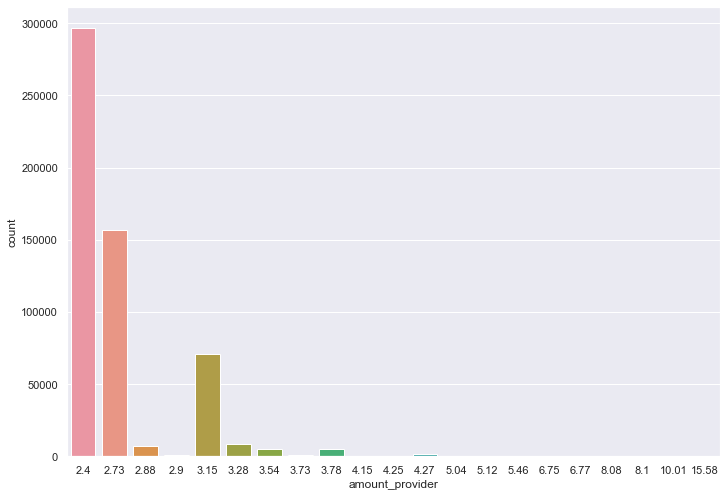

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
full_df.round({'amount_product': 2, 'amount_provider': 2})
plotAmtProvider = sns.countplot(x='amount_provider',data=full_df.round(2))


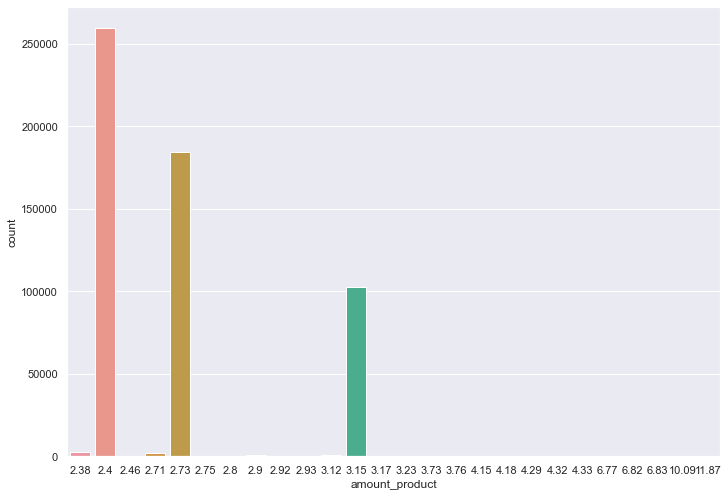

In [358]:
plotAmtProduct = sns.countplot(x="amount_product",data=full_df.round(2))

In [359]:
print('a')

a


<AxesSubplot:xlabel='weight_measured', ylabel='amount_provider'>

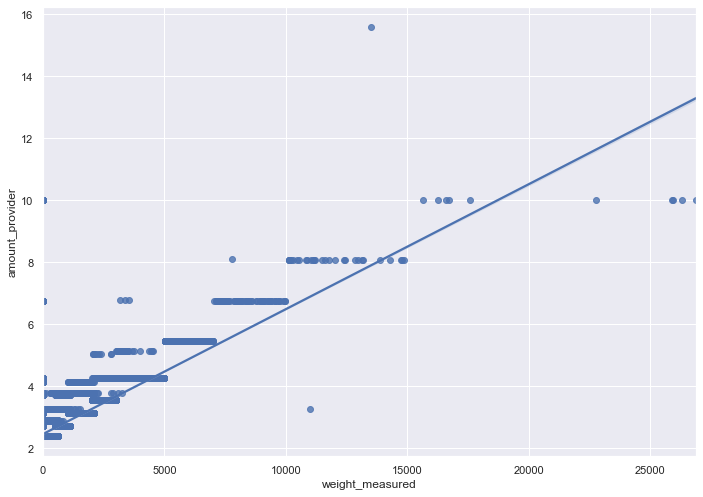

In [362]:
sns.regplot(x=full_df["weight_measured"], y=full_df["amount_provider"])

<AxesSubplot:xlabel='weight_measured', ylabel='amount_product'>

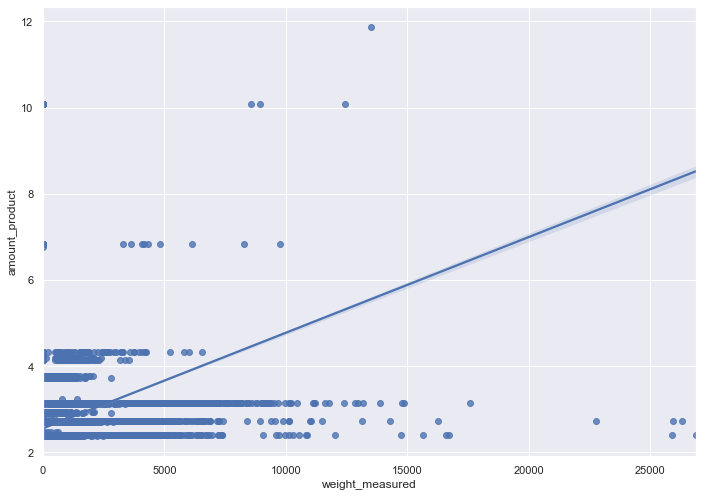

In [363]:
sns.regplot(x=full_df["weight_measured"], y=full_df["amount_product"])

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

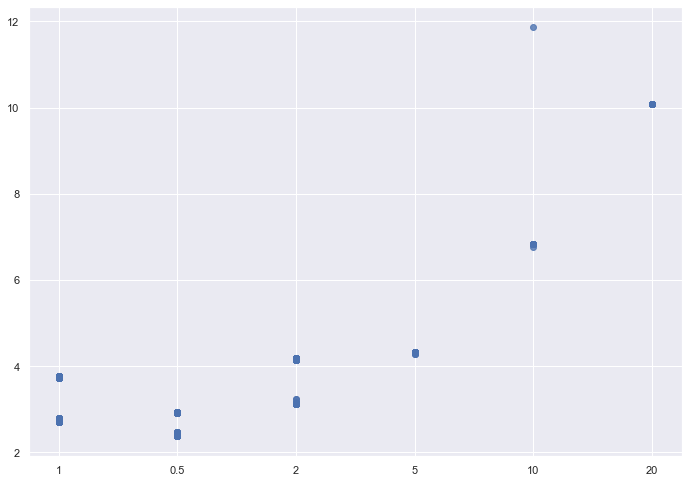

In [364]:
sns.regplot(x=full_df["weight_reported"], y=full_df["amount_product"])

Q2Growth rate: Do number of orders increase with time? Do number of sellers increase with time? how many shippings does a seller do? how many  orders does a single buyer receive? are packages becoming heavier? trends according to countries

Churn - the rate of losing customers (retention rate)

Q3 if numbers of shippings are increasing, Vinted could negotiate lower prices with the shipping companies as it is becoming a bigger customer